Calculando campo en plano XY (Z=0) para Helmholtz...
Calculando campo en plano XY (Z=0) para Anti-Helmholtz...


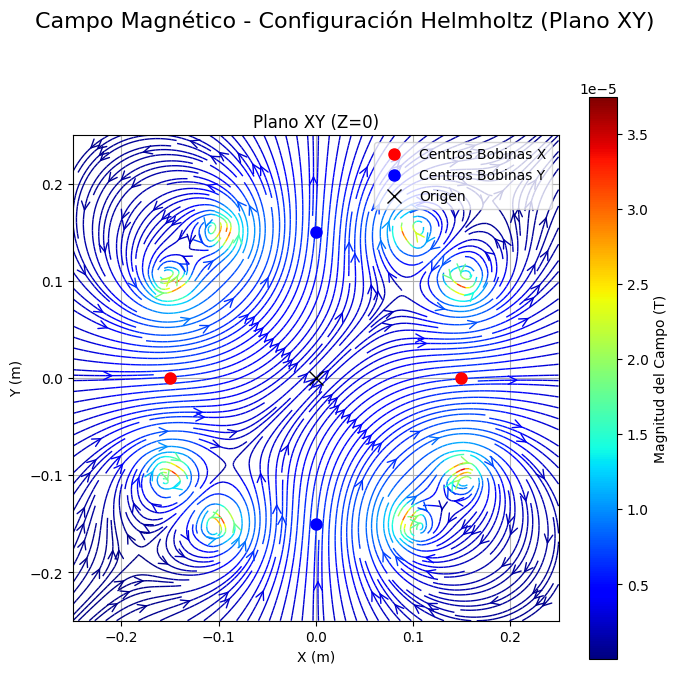

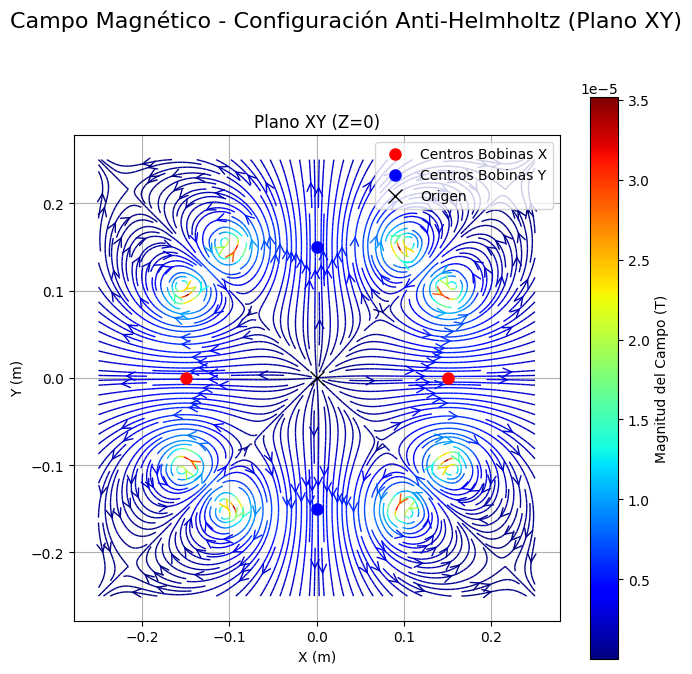


--- Verificación del campo en el origen ---
Campo magnético en el origen (0,0,0) para Helmholtz: [2.14479023e-06 2.14479023e-06 4.76239099e-22] T
Magnitud del campo en el origen para Helmholtz: 3.0331914308949768e-06 T
Campo magnético en el origen (0,0,0) para Anti-Helmholtz: [0.00000000e+00 0.00000000e+00 4.76239099e-22] T
Magnitud del campo en el origen para Anti-Helmholtz: 4.762390991392452e-22 T


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import ellipk, ellipe
import matplotlib.cm as cm # Import colormap module

# Constantes físicas
mu0 = 4 * np.pi * 1e-7  # Permeabilidad del vacío

# --- Parámetros de las bobinas ---
R = 0.1  # Radio de cada espira (en metros)
N = 1    # Número de espiras por bobina (simplificamos a 1 espira por el momento para la fórmula)
a = 0.15 # Distancia de los centros al origen (en metros). Usamos el valor original del usuario.

# --- Función para el campo magnético de una espira circular ---
# Esta función calcula el campo B en un punto (xp, yp, zp) debido a una espira
# de radio R en el plano XY centrada en (0,0,0) con corriente I.
def B_loop_xy_plane(xp, yp, zp, R, I):
    rho = np.sqrt(xp**2 + yp**2)

    # Maneja el caso donde rho es muy cercano a 0 (en el eje z) para evitar división por cero
    if rho < 1e-10: # En el eje z
        Bz = mu0 * I * R**2 / (2 * (R**2 + zp**2)**(1.5))
        return np.array([0.0, 0.0, Bz])

    k_squared_num = 4 * R * rho
    k_squared_den = (R + rho)**2 + zp**2

    if k_squared_den == 0:
        return np.array([0.0, 0.0, 0.0])

    k_squared = k_squared_num / k_squared_den

    # Verificaciones de estabilidad numérica para k_squared
    if k_squared > 1:
        k_squared = 1.0
    elif k_squared < 0:
        k_squared = 0.0

    K_val = ellipk(k_squared)
    E_val = ellipe(k_squared)

    # Componentes del campo en coordenadas cilíndricas
    # Pequeña modificación para estabilidad numérica cuando (R-rho)^2 + zp^2 es muy pequeño
    den_Brho = (R - rho)**2 + zp**2
    if den_Brho < 1e-18: # Evitar división por cero o números muy pequeños
        B_rho = 0.0
    else:
        B_rho = mu0 * I * zp / (2 * np.pi * rho * np.sqrt(k_squared_den)) * \
                ( (R**2 + rho**2 + zp**2) / den_Brho * E_val - K_val )

    den_Bz = (R - rho)**2 + zp**2
    if den_Bz < 1e-18: # Evitar división por cero o números muy pequeños
        B_z = mu0 * I / (2 * np.pi * np.sqrt(k_squared_den)) * K_val
    else:
        B_z = mu0 * I / (2 * np.pi * np.sqrt(k_squared_den)) * \
              ( (R**2 - rho**2 - zp**2) / den_Bz * E_val + K_val )

    # Convertir a coordenadas cartesianas
    Bx = B_rho * xp / rho
    By = B_rho * yp / rho
    Bz = B_z

    return np.array([Bx, By, Bz])


# --- Función para calcular el campo total en un punto ---
# Ahora acepta la configuración de bobinas como argumento
def calculate_total_B(point, coils_config):
    total_B = np.array([0.0, 0.0, 0.0]) # Inicializa total_B correctamente
    for center, normal, current in coils_config:
        vec_to_point = point - center

        # Determina la matriz de rotación para alinear la normal de la bobina con el eje Z
        if np.allclose(normal, [0,0,1]) or np.allclose(normal, [0,0,-1]):
            rotated_point = vec_to_point
            rotation_matrix = np.eye(3) # Matriz identidad para la rotación de vuelta
        else:
            rotation_axis = np.cross(normal, [0,0,1])
            rotation_axis_norm = np.linalg.norm(rotation_axis)

            if rotation_axis_norm < 1e-10: # Coincidente u opuesto a [0,0,1]
                rotation_matrix = np.eye(3)
                if np.dot(normal, [0,0,1]) < 0: # Si la normal es [0,0,-1], invierte Z
                    rotation_matrix = np.array([
                        [1, 0, 0],
                        [0, 1, 0],
                        [0, 0, -1]
                    ])
            else:
                rotation_axis = rotation_axis / rotation_axis_norm
                angle = np.arccos(np.dot(normal, [0,0,1]))
                K = np.array([
                    [0, -rotation_axis[2], rotation_axis[1]],
                    [rotation_axis[2], 0, -rotation_axis[0]],
                    [-rotation_axis[1], rotation_axis[0], 0]
                ])
                rotation_matrix = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * np.dot(K, K)

            rotated_point = np.dot(rotation_matrix, vec_to_point)

        B_coil_cs = B_loop_xy_plane(rotated_point[0], rotated_point[1], rotated_point[2], R, current)

        # Rota el campo B calculado de vuelta al sistema de coordenadas global
        total_B += np.dot(rotation_matrix.T, B_coil_cs)

    return total_B

# --- Definición de las Bobinas ---
I_mag = 1.0 # Amperios

# --- Configuración Helmholtz (Aditivo) en plano XY (4 bobinas) ---
# Las corrientes se suman para crear un campo más uniforme en el centro del plano XY
helmholtz_coil1_center = np.array([0.0, a, 0.0])
helmholtz_coil1_normal = np.array([0.0, 1.0, 0.0]) # Apunta en Y+
helmholtz_coil1_I_mult = 1.0

helmholtz_coil2_center = np.array([0.0, -a, 0.0])
helmholtz_coil2_normal = np.array([0.0, 1.0, 0.0]) # Apunta en Y+ (misma dirección)
helmholtz_coil2_I_mult = 1.0

helmholtz_coil3_center = np.array([a, 0.0, 0.0])
helmholtz_coil3_normal = np.array([1.0, 0.0, 0.0]) # Apunta en X+
helmholtz_coil3_I_mult = 1.0

helmholtz_coil4_center = np.array([-a, 0.0, 0.0])
helmholtz_coil4_normal = np.array([1.0, 0.0, 0.0]) # Apunta en X+ (misma dirección)
helmholtz_coil4_I_mult = 1.0

helmholtz_coils = [
    (helmholtz_coil1_center, helmholtz_coil1_normal, helmholtz_coil1_I_mult * I_mag),
    (helmholtz_coil2_center, helmholtz_coil2_normal, helmholtz_coil2_I_mult * I_mag),
    (helmholtz_coil3_center, helmholtz_coil3_normal, helmholtz_coil3_I_mult * I_mag),
    (helmholtz_coil4_center, helmholtz_coil4_normal, helmholtz_coil4_I_mult * I_mag)
]

# --- Configuración Anti-Helmholtz (No Aditivo) en plano XY (4 bobinas) ---
# Las corrientes se oponen para crear un gradiente de campo en el centro del plano XY
antihelmholtz_coil1_center = np.array([0.0, a, 0.0])
antihelmholtz_coil1_normal = np.array([0.0, 1.0, 0.0]) # Apunta en Y+
antihelmholtz_coil1_I_mult = 1.0

antihelmholtz_coil2_center = np.array([0.0, -a, 0.0])
antihelmholtz_coil2_normal = np.array([0.0, -1.0, 0.0]) # Apunta en Y- (dirección opuesta)
antihelmholtz_coil2_I_mult = 1.0

antihelmholtz_coil3_center = np.array([a, 0.0, 0.0])
antihelmholtz_coil3_normal = np.array([1.0, 0.0, 0.0]) # Apunta en X+
antihelmholtz_coil3_I_mult = 1.0

antihelmholtz_coil4_center = np.array([-a, 0.0, 0.0])
antihelmholtz_coil4_normal = np.array([-1.0, 0.0, 0.0]) # Apunta en X- (dirección opuesta)
antihelmholtz_coil4_I_mult = 1.0

antihelmholtz_coils = [
    (antihelmholtz_coil1_center, antihelmholtz_coil1_normal, antihelmholtz_coil1_I_mult * I_mag),
    (antihelmholtz_coil2_center, antihelmholtz_coil2_normal, antihelmholtz_coil2_I_mult * I_mag),
    (antihelmholtz_coil3_center, antihelmholtz_coil3_normal, antihelmholtz_coil3_I_mult * I_mag),
    (antihelmholtz_coil4_center, antihelmholtz_coil4_normal, antihelmholtz_coil4_I_mult * I_mag)
]

# --- Configuración para la visualización ---
rho = 3 # Densidad de las líneas de campo para streamplot

# --- Malla de puntos y cálculo para Helmholtz (H) en el plano XY ---
NxH, Ny_xyH = 30, 30 # Aumentamos la resolución para una mejor visualización
x_valsH = np.linspace(-0.25, 0.25, NxH)
y_vals_xyH = np.linspace(-0.25, 0.25, Ny_xyH)
X_xyH, Y_xyH = np.meshgrid(x_valsH, y_vals_xyH)
Z_xyH = np.zeros_like(X_xyH) # z = 0 (Plano XY)

Bx_xyH, By_xyH, Bz_xyH = np.zeros(X_xyH.shape), np.zeros(X_xyH.shape), np.zeros(X_xyH.shape)

print("Calculando campo en plano XY (Z=0) para Helmholtz...")
for i in range(NxH):
    for j in range(Ny_xyH):
        point = np.array([X_xyH[i, j], Y_xyH[i, j], Z_xyH[i, j]])
        B_fieldH = calculate_total_B(point, helmholtz_coils) # Usar helmholtz_coils
        Bx_xyH[i, j] = B_fieldH[0]
        By_xyH[i, j] = B_fieldH[1]
        Bz_xyH[i, j] = B_fieldH[2]


# --- Malla de puntos y cálculo para Anti-Helmholtz (AH) en el plano XY ---
NxAH, Ny_xyAH = 30, 30 # Aumentamos la resolución para una mejor visualización
x_valsAH = np.linspace(-0.25, 0.25, NxAH)
y_vals_xyAH = np.linspace(-0.25, 0.25, Ny_xyAH)
X_xyAH, Y_xyAH = np.meshgrid(x_valsAH, y_vals_xyAH)
Z_xyAH = np.zeros_like(X_xyAH) # z = 0 (Plano XY)

Bx_xyAH, By_xyAH, Bz_xyAH = np.zeros(X_xyAH.shape), np.zeros(X_xyAH.shape), np.zeros(X_xyAH.shape)

print("Calculando campo en plano XY (Z=0) para Anti-Helmholtz...")
for i in range(NxAH):
    for j in range(Ny_xyAH):
        point = np.array([X_xyAH[i, j], Y_xyAH[i, j], Z_xyAH[i, j]])
        B_fieldAH = calculate_total_B(point, antihelmholtz_coils) # Usar antihelmholtz_coils
        Bx_xyAH[i, j] = B_fieldAH[0]
        By_xyAH[i, j] = B_fieldAH[1]
        Bz_xyAH[i, j] = B_fieldAH[2]


# --- Visualización para Helmholtz (H) ---
fig_H = plt.figure(figsize=(7, 7)) # Ajustado el tamaño para un solo subplot
fig_H.suptitle('Campo Magnético - Configuración Helmholtz (Plano XY)', fontsize=16)

# Plot en el plano XY (Z=0) para Helmholtz
ax_H = fig_H.add_subplot(111) # Un solo subplot
magnitude_xyH = np.sqrt(Bx_xyH**2 + By_xyH**2 + Bz_xyH**2)
strm_xyH = ax_H.streamplot(X_xyH, Y_xyH, Bx_xyH, By_xyH, color=magnitude_xyH, cmap='jet', linewidth=1, density=rho, arrowstyle='->', arrowsize=1.5)
ax_H.set_title('Plano XY (Z=0)')
ax_H.set_xlabel('X (m)')
ax_H.set_ylabel('Y (m)')
ax_H.set_aspect('equal', adjustable='box')
ax_H.grid(True)
# Las bobinas están en el eje X y Y. Marcamos sus centros.
ax_H.plot([a, -a], [0, 0], 'ro', markersize=8, label='Centros Bobinas X')
ax_H.plot([0, 0], [a, -a], 'bo', markersize=8, label='Centros Bobinas Y')
ax_H.plot(0, 0, 'kx', markersize=10, label='Origen')
ax_H.legend(loc='upper right')
cbar_H = plt.colorbar(cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=magnitude_xyH.min(), vmax=magnitude_xyH.max())), ax=ax_H, label='Magnitud del Campo (T)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar el layout para dejar espacio para el título principal
plt.savefig('helmholtz_xy_field.png') # Guarda la imagen del campo Helmholtz
plt.show()


# --- Visualización para Anti-Helmholtz (AH) ---
fig_AH = plt.figure(figsize=(7, 7)) # Ajustado el tamaño para un solo subplot
fig_AH.suptitle('Campo Magnético - Configuración Anti-Helmholtz (Plano XY)', fontsize=16)

# Plot en el plano XY (Z=0) para Anti-Helmholtz
ax_AH = fig_AH.add_subplot(111) # Un solo subplot
magnitude_xyAH = np.sqrt(Bx_xyAH**2 + By_xyAH**2 + Bz_xyAH**2)
strm_xyAH = ax_AH.streamplot(X_xyAH, Y_xyAH, Bx_xyAH, By_xyAH, color=magnitude_xyAH, cmap='jet', linewidth=1, density=rho, arrowstyle='->', arrowsize=1.5)
ax_AH.set_title('Plano XY (Z=0)')
ax_AH.set_xlabel('X (m)')
ax_AH.set_ylabel('Y (m)')
ax_AH.set_aspect('equal', adjustable='box')
ax_AH.grid(True)
# Las bobinas están en el eje X y Y. Marcamos sus centros.
ax_AH.plot([a, -a], [0, 0], 'ro', markersize=8, label='Centros Bobinas X')
ax_AH.plot([0, 0], [a, -a], 'bo', markersize=8, label='Centros Bobinas Y')
ax_AH.plot(0, 0, 'kx', markersize=10, label='Origen')
ax_AH.legend(loc='upper right')
cbar_AH = plt.colorbar(cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=magnitude_xyAH.min(), vmax=magnitude_xyAH.max())), ax=ax_AH, label='Magnitud del Campo (T)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar el layout para dejar espacio para el título principal
plt.savefig('antihelmholtz_xy_field.png') # Guarda la imagen del campo Anti-Helmholtz
plt.show()

# --- Verificación del campo en el origen ---
print("\n--- Verificación del campo en el origen ---")
origin_field_H = calculate_total_B(np.array([0.0, 0.0, 0.0]), helmholtz_coils)
print(f"Campo magnético en el origen (0,0,0) para Helmholtz: {origin_field_H} T")
print(f"Magnitud del campo en el origen para Helmholtz: {np.linalg.norm(origin_field_H)} T")

origin_field_AH = calculate_total_B(np.array([0.0, 0.0, 0.0]), antihelmholtz_coils)
print(f"Campo magnético en el origen (0,0,0) para Anti-Helmholtz: {origin_field_AH} T")
print(f"Magnitud del campo en el origen para Anti-Helmholtz: {np.linalg.norm(origin_field_AH)} T")


Calculando campo en plano XY (Z=0) para Helmholtz-like (Dipolos)...
Calculando campo en plano XY (Z=0) para Anti-Helmholtz-like (Dipolos)...


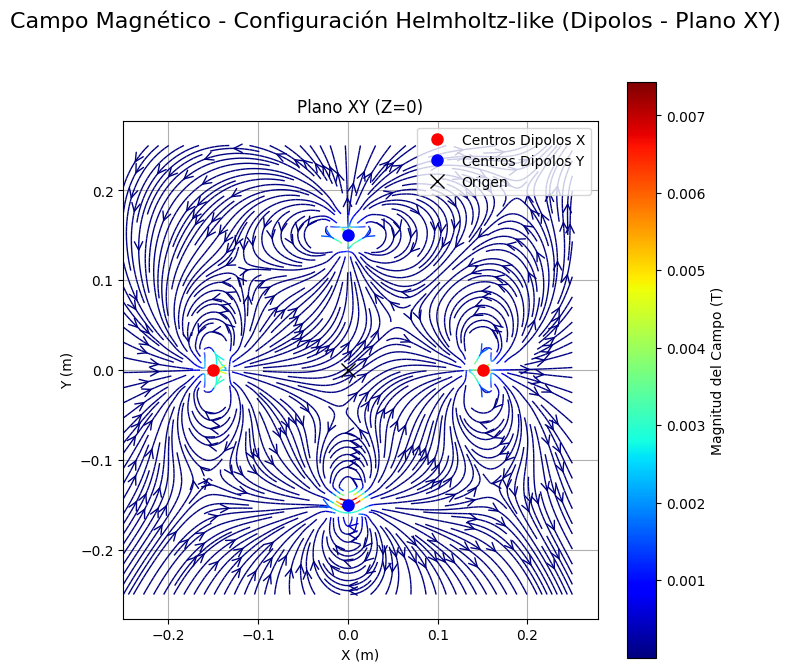

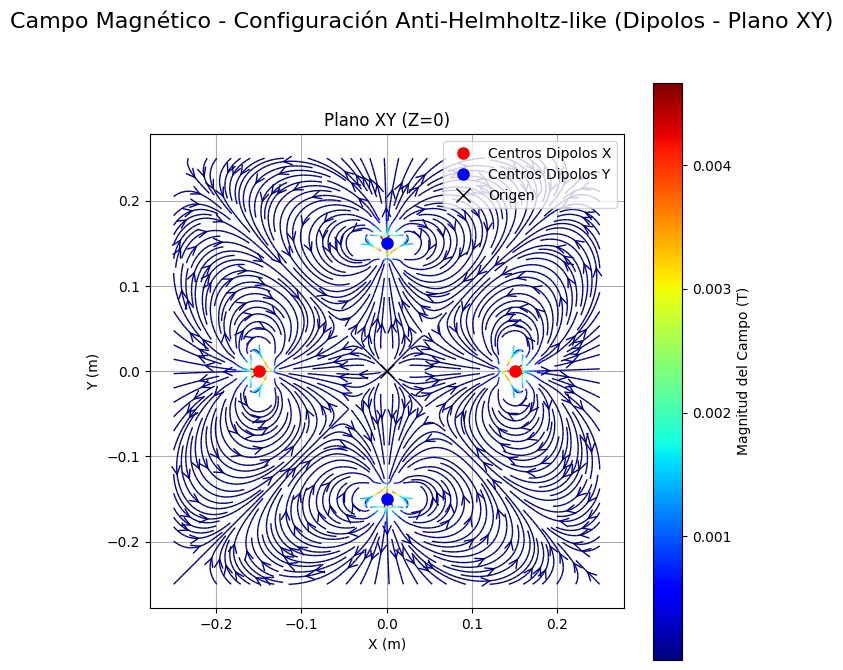


--- Verificación del campo en el origen ---
Campo magnético en el origen (0,0,0) para Helmholtz-like (Dipolos): [2.79252680e-06 1.86168454e-06 0.00000000e+00] T
Magnitud del campo en el origen para Helmholtz-like (Dipolos): 3.3561995256708086e-06 T
Campo magnético en el origen (0,0,0) para Anti-Helmholtz-like (Dipolos): [0. 0. 0.] T
Magnitud del campo en el origen para Anti-Helmholtz-like (Dipolos): 0.0 T


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Aunque no se usa directamente para plot 3D, se mantiene por si acaso
from scipy.special import ellipk, ellipe # No se usa para dipolos, pero se mantiene si la función B_loop_xy_plane se reutiliza
import matplotlib.cm as cm # Import colormap module

# Constantes físicas
mu0 = 4 * np.pi * 1e-7  # Permeabilidad del vacío

# --- Parámetros de los "dipolos" (análogos a las bobinas) ---
R = 0.1  # Radio de la espira equivalente (usado para calcular el momento dipolar)
A = np.pi * R**2 # Área de la espira equivalente
N = 1    # Número de espiras (simplificamos, N=1 para I*A directo)
a = 0.15 # Distancia de los centros al origen (en metros).

# --- Función para el campo magnético de un dipolo magnético ---
# Esta función calcula el campo B en un punto 'r_point'
# debido a un dipolo magnético 'm_vec' ubicado en 'dipole_pos'.
def B_dipole(r_point, dipole_pos, m_vec):
    r_vec = r_point - dipole_pos # Vector desde el dipolo al punto de observación
    r_mag = np.linalg.norm(r_vec) # Magnitud de la distancia

    # Para evitar singularidades en la ubicación del dipolo
    if r_mag < 1e-6: # Umbral para evitar división por cero o valores muy grandes
        return np.array([0.0, 0.0, 0.0])

    # Fórmula del campo magnético para un dipolo
    B_field = (mu0 / (4 * np.pi)) * \
              ( (3 * r_vec * np.dot(m_vec, r_vec)) / (r_mag**5) - m_vec / (r_mag**3) )

    return B_field

# --- Definición de los Dipolos ---
I_mag = 1.0 # Amperios (corriente de la bobina equivalente)
m_magnitude = I_mag * A * N # Magnitud del momento dipolar magnético (m = I * A * N)

# --- Configuración Helmholtz-like (Aditivo) con Dipolos ---
# Para un campo aditivo en el origen (similar a Helmholtz para bobinas co-axiales),
# los momentos dipolares deben ser paralelos en cada eje.
# Esto significa que el campo que producen en el origen se sumará.
helmholtz_dipole1_pos = np.array([0.0, a, 0.0])
helmholtz_dipole1_m_vec = np.array([0.0, 1.0, 0.0]) * m_magnitude # Momento en +Y

helmholtz_dipole2_pos = np.array([0.0, -a, 0.0])
helmholtz_dipole2_m_vec = np.array([1.0, 0.0, 0.0]) * m_magnitude # Momento en +Y (paralelo)

helmholtz_dipole3_pos = np.array([a, 0.0, 0.0])
helmholtz_dipole3_m_vec = np.array([1.0, 0.0, 0.0]) * m_magnitude # Momento en +X

helmholtz_dipole4_pos = np.array([-a, 0.0, 0.0])
helmholtz_dipole4_m_vec = np.array([1.0, 0.0, 0.0]) * m_magnitude # Momento en +X (paralelo)

helmholtz_dipoles = [
    (helmholtz_dipole1_pos, helmholtz_dipole1_m_vec),
    (helmholtz_dipole2_pos, helmholtz_dipole2_m_vec),
    (helmholtz_dipole3_pos, helmholtz_dipole3_m_vec),
    (helmholtz_dipole4_pos, helmholtz_dipole4_m_vec)
]

# --- Configuración Anti-Helmholtz-like (No Aditivo/Gradiente) con Dipolos ---
# Para un campo nulo en el origen y un gradiente (similar a Anti-Helmholtz para bobinas co-axiales),
# los momentos dipolares en cada eje deben ser anti-paralelos.
# Esto significa que el campo que producen en el origen se cancelará.
antihelmholtz_dipole1_pos = np.array([0.0, a, 0.0])
antihelmholtz_dipole1_m_vec = np.array([0.0, 1.0, 0.0]) * m_magnitude # Momento en +Y

antihelmholtz_dipole2_pos = np.array([0.0, -a, 0.0])
antihelmholtz_dipole2_m_vec = np.array([0.0, -1.0, 0.0]) * m_magnitude # Momento en -Y (anti-paralelo)

antihelmholtz_dipole3_pos = np.array([a, 0.0, 0.0])
antihelmholtz_dipole3_m_vec = np.array([1.0, 0.0, 0.0]) * m_magnitude # Momento en +X

antihelmholtz_dipole4_pos = np.array([-a, 0.0, 0.0])
antihelmholtz_dipole4_m_vec = np.array([-1.0, 0.0, 0.0]) * m_magnitude # Momento en -X (anti-paralelo)

antihelmholtz_dipoles = [
    (antihelmholtz_dipole1_pos, antihelmholtz_dipole1_m_vec),
    (antihelmholtz_dipole2_pos, antihelmholtz_dipole2_m_vec),
    (antihelmholtz_dipole3_pos, antihelmholtz_dipole3_m_vec),
    (antihelmholtz_dipole4_pos, antihelmholtz_dipole4_m_vec)
]

# --- Función para calcular el campo total de dipolos en un punto ---
def calculate_total_B_dipoles(point, dipoles_config):
    total_B = np.array([0.0, 0.0, 0.0])
    for dipole_pos, m_vec in dipoles_config:
        total_B += B_dipole(point, dipole_pos, m_vec)
    return total_B

# --- Configuración para la visualización ---
rho_density = 3 # Densidad de las líneas de campo para streamplot

# --- Malla de puntos y cálculo para Helmholtz-like (H) en el plano XY ---
NxH, Ny_xyH = 30, 30 # Resolución para una mejor visualización
x_valsH = np.linspace(-0.25, 0.25, NxH)
y_vals_xyH = np.linspace(-0.25, 0.25, Ny_xyH)
X_xyH, Y_xyH = np.meshgrid(x_valsH, y_vals_xyH)
Z_xyH = np.zeros_like(X_xyH) # z = 0 (Plano XY)

Bx_xyH, By_xyH, Bz_xyH = np.zeros(X_xyH.shape), np.zeros(X_xyH.shape), np.zeros(X_xyH.shape)

print("Calculando campo en plano XY (Z=0) para Helmholtz-like (Dipolos)...")
for i in range(NxH):
    for j in range(Ny_xyH):
        point = np.array([X_xyH[i, j], Y_xyH[i, j], Z_xyH[i, j]])
        B_fieldH = calculate_total_B_dipoles(point, helmholtz_dipoles) # Usar helmholtz_dipoles
        Bx_xyH[i, j] = B_fieldH[0]
        By_xyH[i, j] = B_fieldH[1]
        Bz_xyH[i, j] = B_fieldH[2]


# --- Malla de puntos y cálculo para Anti-Helmholtz-like (AH) en el plano XY ---
NxAH, Ny_xyAH = 30, 30 # Resolución para una mejor visualización
x_valsAH = np.linspace(-0.25, 0.25, NxAH)
y_vals_xyAH = np.linspace(-0.25, 0.25, Ny_xyAH)
X_xyAH, Y_xyAH = np.meshgrid(x_valsAH, y_vals_xyAH)
Z_xyAH = np.zeros_like(X_xyAH) # z = 0 (Plano XY)

Bx_xyAH, By_xyAH, Bz_xyAH = np.zeros(X_xyAH.shape), np.zeros(X_xyAH.shape), np.zeros(X_xyAH.shape)

print("Calculando campo en plano XY (Z=0) para Anti-Helmholtz-like (Dipolos)...")
for i in range(NxAH):
    for j in range(Ny_xyAH):
        point = np.array([X_xyAH[i, j], Y_xyAH[i, j], Z_xyAH[i, j]])
        B_fieldAH = calculate_total_B_dipoles(point, antihelmholtz_dipoles) # Usar antihelmholtz_dipoles
        Bx_xyAH[i, j] = B_fieldAH[0]
        By_xyAH[i, j] = B_fieldAH[1]
        Bz_xyAH[i, j] = B_fieldAH[2]


# --- Visualización para Helmholtz-like (H) ---
fig_H = plt.figure(figsize=(7, 7)) # Ajustado el tamaño para un solo subplot
fig_H.suptitle('Campo Magnético - Configuración Helmholtz-like (Dipolos - Plano XY)', fontsize=16)

# Plot en el plano XY (Z=0) para Helmholtz-like
ax_H = fig_H.add_subplot(111) # Un solo subplot
magnitude_xyH = np.sqrt(Bx_xyH**2 + By_xyH**2 + Bz_xyH**2)
strm_xyH = ax_H.streamplot(X_xyH, Y_xyH, Bx_xyH, By_xyH, color=magnitude_xyH, cmap='jet', linewidth=1, density=rho_density, arrowstyle='->', arrowsize=1.5)
ax_H.set_title('Plano XY (Z=0)')
ax_H.set_xlabel('X (m)')
ax_H.set_ylabel('Y (m)')
ax_H.set_aspect('equal', adjustable='box')
ax_H.grid(True)
# Los dipolos están en el eje X y Y. Marcamos sus centros.
ax_H.plot([a, -a], [0, 0], 'ro', markersize=8, label='Centros Dipolos X')
ax_H.plot([0, 0], [a, -a], 'bo', markersize=8, label='Centros Dipolos Y')
ax_H.plot(0, 0, 'kx', markersize=10, label='Origen')
ax_H.legend(loc='upper right')
cbar_H = plt.colorbar(cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=magnitude_xyH.min(), vmax=magnitude_xyH.max())), ax=ax_H, label='Magnitud del Campo (T)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar el layout para dejar espacio para el título principal
plt.savefig('helmholtz_dipoles_xy_field.png') # Guarda la imagen del campo Helmholtz-like
plt.show()


# --- Visualización para Anti-Helmholtz-like (AH) ---
fig_AH = plt.figure(figsize=(7, 7)) # Ajustado el tamaño para un solo subplot
fig_AH.suptitle('Campo Magnético - Configuración Anti-Helmholtz-like (Dipolos - Plano XY)', fontsize=16)

# Plot en el plano XY (Z=0) para Anti-Helmholtz-like
ax_AH = fig_AH.add_subplot(111) # Un solo subplot
magnitude_xyAH = np.sqrt(Bx_xyAH**2 + By_xyAH**2 + Bz_xyAH**2)
strm_xyAH = ax_AH.streamplot(X_xyAH, Y_xyAH, Bx_xyAH, By_xyAH, color=magnitude_xyAH, cmap='jet', linewidth=1, density=rho_density, arrowstyle='->', arrowsize=1.5)
ax_AH.set_title('Plano XY (Z=0)')
ax_AH.set_xlabel('X (m)')
ax_AH.set_ylabel('Y (m)')
ax_AH.set_aspect('equal', adjustable='box')
ax_AH.grid(True)
# Los dipolos están en el eje X y Y. Marcamos sus centros.
ax_AH.plot([a, -a], [0, 0], 'ro', markersize=8, label='Centros Dipolos X')
ax_AH.plot([0, 0], [a, -a], 'bo', markersize=8, label='Centros Dipolos Y')
ax_AH.plot(0, 0, 'kx', markersize=10, label='Origen')
ax_AH.legend(loc='upper right')

cbar_AH = plt.colorbar(cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=magnitude_xyAH.min(), vmax=magnitude_xyAH.max())), ax=ax_AH, label='Magnitud del Campo (T)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar el layout para dejar espacio para el título principal
plt.savefig('antihelmholtz_dipoles_xy_field.png') # Guarda la imagen del campo Anti-Helmholtz-like
plt.show()

# --- Verificación del campo en el origen ---
print("\n--- Verificación del campo en el origen ---")
origin_field_H = calculate_total_B_dipoles(np.array([0.0, 0.0, 0.0]), helmholtz_dipoles)
print(f"Campo magnético en el origen (0,0,0) para Helmholtz-like (Dipolos): {origin_field_H} T")
print(f"Magnitud del campo en el origen para Helmholtz-like (Dipolos): {np.linalg.norm(origin_field_H)} T")

origin_field_AH = calculate_total_B_dipoles(np.array([0.0, 0.0, 0.0]), antihelmholtz_dipoles)
print(f"Campo magnético en el origen (0,0,0) para Anti-Helmholtz-like (Dipolos): {origin_field_AH} T")
print(f"Magnitud del campo en el origen para Anti-Helmholtz-like (Dipolos): {np.linalg.norm(origin_field_AH)} T")


Calculando campo en plano XY (Z=0) para Helmholtz-like (Cuadrupolos)...
Calculando campo en plano XY (Z=0) para Anti-Helmholtz-like (Cuadrupolos)...


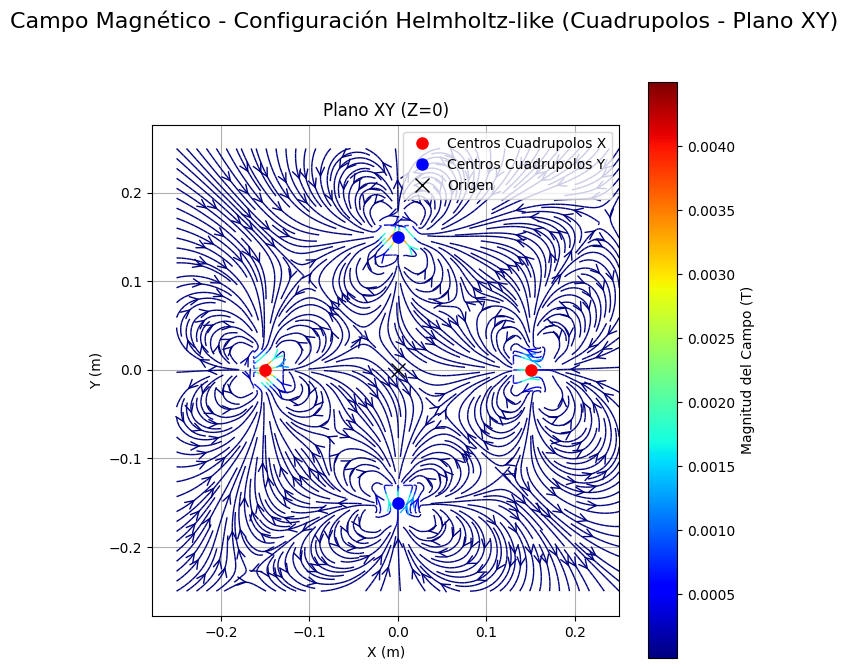

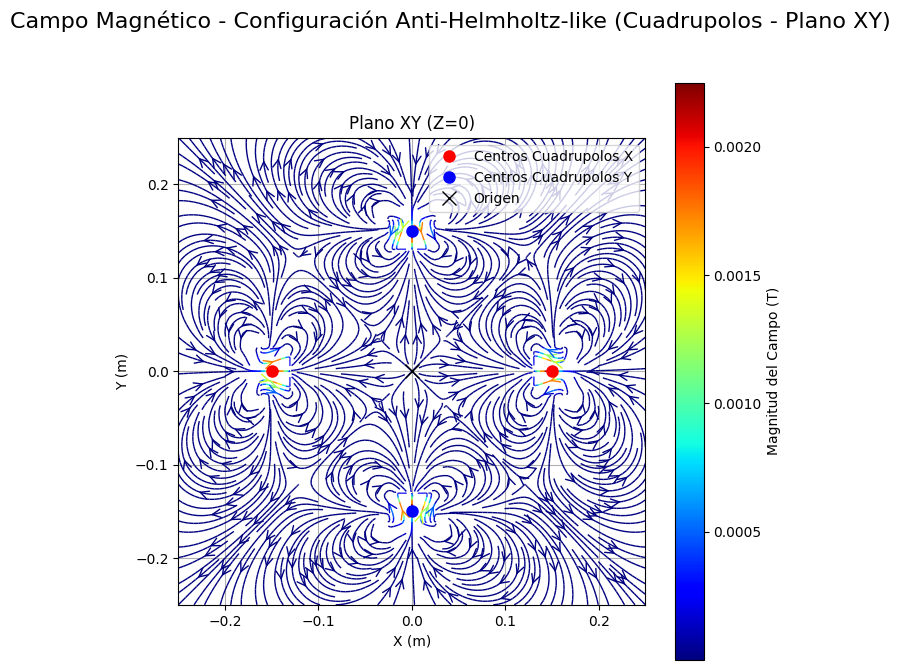


--- Verificación del campo en el origen ---
Campo magnético en el origen (0,0,0) para Helmholtz-like (Cuadrupolos): [ 1.11707969e-07 -1.11707969e-07  0.00000000e+00] T
Magnitud del campo en el origen para Helmholtz-like (Cuadrupolos): 1.5797892422923568e-07 T
Campo magnético en el origen (0,0,0) para Anti-Helmholtz-like (Cuadrupolos): [0. 0. 0.] T
Magnitud del campo en el origen para Anti-Helmholtz-like (Cuadrupolos): 0.0 T


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Import colormap module

# Constantes físicas
mu0 = 4 * np.pi * 1e-7  # Permeabilidad del vacío

# --- Parámetros de los "cuadrupolos" (análogos a las bobinas) ---
R = 0.1  # Radio de la espira equivalente (usado para calcular el momento dipolar interno)
A = np.pi * R**2 # Área de la espira equivalente
N = 1    # Número de espiras (simplificamos, N=1 para I*A directo)
a = 0.15 # Distancia de los centros de los cuadrupolos al origen (en metros).

# Parámetro adicional para el cuadrupolo: pequeña distancia para la separación de los dipolos internos
delta = R / 50 # Un valor pequeño para modelar el cuadrupolo como dos dipolos desplazados

# --- Función para el campo magnético de un dipolo magnético ---
# Esta función calcula el campo B en un punto 'r_point'
# debido a un dipolo magnético 'm_vec' ubicado en 'dipole_pos'.
def B_dipole(r_point, dipole_pos, m_vec):
    r_vec = r_point - dipole_pos # Vector desde el dipolo al punto de observación
    r_mag = np.linalg.norm(r_vec) # Magnitud de la distancia

    # Para evitar singularidades en la ubicación del dipolo
    if r_mag < 1e-6: # Umbral para evitar división por cero o valores muy grandes
        return np.array([0.0, 0.0, 0.0])

    # Fórmula del campo magnético para un dipolo
    B_field = (mu0 / (4 * np.pi)) * \
              ( (3 * r_vec * np.dot(m_vec, r_vec)) / (r_mag**5) - m_vec / (r_mag**3) )

    return B_field

# --- Función para el campo magnético de un cuadrupolo magnético ---
# Un cuadrupolo se modela como dos dipolos antiparalelos ligeramente desplazados.
# quad_axis_direction: la dirección del eje del cuadrupolo.
# m_magnitude: la magnitud del momento dipolar de cada dipolo interno.
def B_quadrupole(r_point, quad_center, quad_axis_direction, m_magnitude):
    # Los dos dipolos que forman el cuadrupolo
    # El primer dipolo tiene momento en la dirección del eje del cuadrupolo
    m_vec_positive = quad_axis_direction * m_magnitude
    # El segundo dipolo tiene momento en la dirección opuesta
    m_vec_negative = -quad_axis_direction * m_magnitude

    # Posiciones de los dipolos internos, desplazados del centro del cuadrupolo
    dipole_pos_positive = quad_center - (quad_axis_direction * delta / 2)
    dipole_pos_negative = quad_center + (quad_axis_direction * delta / 2)

    # Suma de los campos de los dos dipolos
    B_field_positive = B_dipole(r_point, dipole_pos_positive, m_vec_positive)
    B_field_negative = B_dipole(r_point, dipole_pos_negative, m_vec_negative)

    return B_field_positive + B_field_negative


# --- Definición de los Cuadrupolos ---
I_mag = 1.0 # Amperios (corriente de la bobina equivalente para el momento dipolar)

# Magnitud del momento dipolar de cada dipolo que compone el cuadrupolo
m_magnitude = I_mag * A * N

# --- Configuración Helmholtz-like (Aditivo) con Cuadrupolos ---
# Para un campo que se suma en el origen (análogo a Helmholtz),
# los ejes de los cuadrupolos en lados opuestos deben ser paralelos.
helmholtz_quadrupole1_center = np.array([0.0, a, 0.0])
helmholtz_quadrupole1_axis = np.array([1.0, 0.0, 0.0]) # Eje del cuadrupolo en +Y

helmholtz_quadrupole2_center = np.array([0.0, -a, 0.0])
helmholtz_quadrupole2_axis = np.array([0.0, 1.0, 0.0]) # Eje del cuadrupolo en +Y (paralelo)

helmholtz_quadrupole3_center = np.array([a, 0.0, 0.0])
helmholtz_quadrupole3_axis = np.array([1.0, 0.0, 0.0]) # Eje del cuadrupolo en +X

helmholtz_quadrupole4_center = np.array([-a, 0.0, 0.0])
helmholtz_quadrupole4_axis = np.array([0.0, 1.0, 0.0]) # Eje del cuadrupolo en +X (paralelo)

helmholtz_quadrupoles = [
    (helmholtz_quadrupole1_center, helmholtz_quadrupole1_axis),
    (helmholtz_quadrupole2_center, helmholtz_quadrupole2_axis),
    (helmholtz_quadrupole3_center, helmholtz_quadrupole3_axis),
    (helmholtz_quadrupole4_center, helmholtz_quadrupole4_axis)
]

# --- Configuración Anti-Helmholtz-like (No Aditivo/Gradiente) con Cuadrupolos ---
# Para un campo nulo en el origen y un gradiente (análogo a Anti-Helmholtz),
# los ejes de los cuadrupolos en lados opuestos deben ser anti-paralelos.
antihelmholtz_quadrupole1_center = np.array([0.0, a, 0.0])
antihelmholtz_quadrupole1_axis = np.array([0.0, -1.0, 0.0]) # Eje del cuadrupolo en +Y

antihelmholtz_quadrupole2_center = np.array([0.0, -a, 0.0])
antihelmholtz_quadrupole2_axis = np.array([0.0, -1.0, 0.0]) # Eje del cuadrupolo en -Y (anti-paralelo)

antihelmholtz_quadrupole3_center = np.array([a, 0.0, 0.0])
antihelmholtz_quadrupole3_axis = np.array([-1.0, 0.0, 0.0]) # Eje del cuadrupolo en +X

antihelmholtz_quadrupole4_center = np.array([-a, 0.0, 0.0])
antihelmholtz_quadrupole4_axis = np.array([-1.0, 0.0, 0.0]) # Eje del cuadrupolo en -X (anti-paralelo)

antihelmholtz_quadrupoles = [
    (antihelmholtz_quadrupole1_center, antihelmholtz_quadrupole1_axis),
    (antihelmholtz_quadrupole2_center, antihelmholtz_quadrupole2_axis),
    (antihelmholtz_quadrupole3_center, antihelmholtz_quadrupole3_axis),
    (antihelmholtz_quadrupole4_center, antihelmholtz_quadrupole4_axis)
]

# --- Función para calcular el campo total de cuadrupolos en un punto ---
# Ahora acepta la configuración de cuadrupolos como argumento
def calculate_total_B_quadrupoles(point, quadrupoles_config):
    total_B = np.array([0.0, 0.0, 0.0])
    for quad_center, quad_axis in quadrupoles_config:
        total_B += B_quadrupole(point, quad_center, quad_axis, m_magnitude)
    return total_B

# --- Configuración para la visualización ---
rho_density = 3 # Densidad de las líneas de campo para streamplot

# --- Malla de puntos y cálculo para Helmholtz-like (H) en el plano XY ---
NxH, Ny_xyH = 30, 30 # Resolución para una mejor visualización
x_valsH = np.linspace(-0.25, 0.25, NxH)
y_vals_xyH = np.linspace(-0.25, 0.25, Ny_xyH)
X_xyH, Y_xyH = np.meshgrid(x_valsH, y_vals_xyH)
Z_xyH = np.zeros_like(X_xyH) # z = 0 (Plano XY)

Bx_xyH, By_xyH, Bz_xyH = np.zeros(X_xyH.shape), np.zeros(X_xyH.shape), np.zeros(X_xyH.shape)

print("Calculando campo en plano XY (Z=0) para Helmholtz-like (Cuadrupolos)...")
for i in range(NxH):
    for j in range(Ny_xyH):
        point = np.array([X_xyH[i, j], Y_xyH[i, j], Z_xyH[i, j]])
        B_fieldH = calculate_total_B_quadrupoles(point, helmholtz_quadrupoles) # Usar helmholtz_quadrupoles
        Bx_xyH[i, j] = B_fieldH[0]
        By_xyH[i, j] = B_fieldH[1]
        Bz_xyH[i, j] = B_fieldH[2]


# --- Malla de puntos y cálculo para Anti-Helmholtz-like (AH) en el plano XY ---
NxAH, Ny_xyAH = 30, 30 # Resolución para una mejor visualización
x_valsAH = np.linspace(-0.25, 0.25, NxAH)
y_vals_xyAH = np.linspace(-0.25, 0.25, Ny_xyAH)
X_xyAH, Y_xyAH = np.meshgrid(x_valsAH, y_vals_xyAH)
Z_xyAH = np.zeros_like(X_xyAH) # z = 0 (Plano XY)

Bx_xyAH, By_xyAH, Bz_xyAH = np.zeros(X_xyAH.shape), np.zeros(X_xyAH.shape), np.zeros(X_xyAH.shape)

print("Calculando campo en plano XY (Z=0) para Anti-Helmholtz-like (Cuadrupolos)...")
for i in range(NxAH):
    for j in range(Ny_xyAH):
        point = np.array([X_xyAH[i, j], Y_xyAH[i, j], Z_xyAH[i, j]])
        B_fieldAH = calculate_total_B_quadrupoles(point, antihelmholtz_quadrupoles) # Usar antihelmholtz_quadrupoles
        Bx_xyAH[i, j] = B_fieldAH[0]
        By_xyAH[i, j] = B_fieldAH[1]
        Bz_xyAH[i, j] = B_fieldAH[2]


# --- Visualización para Helmholtz-like (H) ---
fig_H = plt.figure(figsize=(7, 7)) # Ajustado el tamaño para un solo subplot
fig_H.suptitle('Campo Magnético - Configuración Helmholtz-like (Cuadrupolos - Plano XY)', fontsize=16)

# Plot en el plano XY (Z=0) para Helmholtz-like
ax_H = fig_H.add_subplot(111) # Un solo subplot
magnitude_xyH = np.sqrt(Bx_xyH**2 + By_xyH**2 + Bz_xyH**2)
strm_xyH = ax_H.streamplot(X_xyH, Y_xyH, Bx_xyH, By_xyH, color=magnitude_xyH, cmap='jet', linewidth=1, density=rho_density, arrowstyle='->', arrowsize=1.5)
ax_H.set_title('Plano XY (Z=0)')
ax_H.set_xlabel('X (m)')
ax_H.set_ylabel('Y (m)')
ax_H.set_aspect('equal', adjustable='box')
ax_H.grid(True)
# Los cuadrupolos están en el eje X y Y. Marcamos sus centros.
ax_H.plot([a, -a], [0, 0], 'ro', markersize=8, label='Centros Cuadrupolos X')
ax_H.plot([0, 0], [a, -a], 'bo', markersize=8, label='Centros Cuadrupolos Y')
ax_H.plot(0, 0, 'kx', markersize=10, label='Origen')
ax_H.legend(loc='upper right')
cbar_H = plt.colorbar(cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=magnitude_xyH.min(), vmax=magnitude_xyH.max())), ax=ax_H, label='Magnitud del Campo (T)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar el layout para dejar espacio para el título principal
plt.savefig('helmholtz_quadrupoles_xy_field.png') # Guarda la imagen del campo Helmholtz-like
plt.show()


# --- Visualización para Anti-Helmholtz-like (AH) ---
fig_AH = plt.figure(figsize=(7, 7)) # Ajustado el tamaño para un solo subplot
fig_AH.suptitle('Campo Magnético - Configuración Anti-Helmholtz-like (Cuadrupolos - Plano XY)', fontsize=16)

# Plot en el plano XY (Z=0) para Anti-Helmholtz-like
ax_AH = fig_AH.add_subplot(111) # Un solo subplot
magnitude_xyAH = np.sqrt(Bx_xyAH**2 + By_xyAH**2 + Bz_xyAH**2)
strm_xyAH = ax_AH.streamplot(X_xyAH, Y_xyAH, Bx_xyAH, By_xyAH, color=magnitude_xyAH, cmap='jet', linewidth=1, density=rho_density, arrowstyle='->', arrowsize=1.5)
ax_AH.set_title('Plano XY (Z=0)')
ax_AH.set_xlabel('X (m)')
ax_AH.set_ylabel('Y (m)')
ax_AH.set_aspect('equal', adjustable='box')
ax_AH.grid(True)
# Los cuadrupolos están en el eje X y Y. Marcamos sus centros.
ax_AH.plot([a, -a], [0, 0], 'ro', markersize=8, label='Centros Cuadrupolos X')
ax_AH.plot([0, 0], [a, -a], 'bo', markersize=8, label='Centros Cuadrupolos Y')
ax_AH.plot(0, 0, 'kx', markersize=10, label='Origen')
ax_AH.legend(loc='upper right')
cbar_AH = plt.colorbar(cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=magnitude_xyAH.min(), vmax=magnitude_xyAH.max())), ax=ax_AH, label='Magnitud del Campo (T)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar el layout para dejar espacio para el título principal
plt.savefig('antihelmholtz_quadrupoles_xy_field.png') # Guarda la imagen del campo Anti-Helmholtz-like
plt.show()

# --- Verificación del campo en el origen ---
print("\n--- Verificación del campo en el origen ---")
origin_field_H = calculate_total_B_quadrupoles(np.array([0.0, 0.0, 0.0]), helmholtz_quadrupoles)
print(f"Campo magnético en el origen (0,0,0) para Helmholtz-like (Cuadrupolos): {origin_field_H} T")
print(f"Magnitud del campo en el origen para Helmholtz-like (Cuadrupolos): {np.linalg.norm(origin_field_H)} T")

origin_field_AH = calculate_total_B_quadrupoles(np.array([0.0, 0.0, 0.0]), antihelmholtz_quadrupoles)
print(f"Campo magnético en el origen (0,0,0) para Anti-Helmholtz-like (Cuadrupolos): {origin_field_AH} T")
print(f"Magnitud del campo en el origen para Anti-Helmholtz-like (Cuadrupolos): {np.linalg.norm(origin_field_AH)} T")
